In [3]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from PIL import Image
from scipy.signal import convolve2d
from skimage.measure import block_reduce, find_contours
from matplotlib.patches import Rectangle
from kural_core.models import *
from kural_core.data_processing import *
from kural_core.functions import *
import pickle
from scipy.misc import imresize
from scipy.ndimage import morphology
from scipy.spatial import ConvexHull
from skimage import measure
from matplotlib import animation, rc
from IPython.display import HTML
import os

PATH = r'D:\Code\kural_work\movie_generation\data\\'
all_files = os.listdir(PATH)
tifs = []
for file in all_files:
    if file[-4:] != '.tif': continue
    tifs.append(file)
    
num_angles = 30
angles = np.array([i*2*np.pi/num_angles for i in range(num_angles)])

In [442]:
ind = 13
tif = tifs[ind]
print(tif)
img_ = Image.open(PATH+tif)
nf = img_.n_frames
img = np.zeros((nf,512,512))
for f in range(nf):
    img_.seek(f)
    img[f] = np.array(img_)
# img[img==0] = 255

s08_30m_2s_50ms_100p.tif


In [443]:
k_mean_img, cent = k_means_classifier(img,6)

Finished iteration 14
Done


In [444]:
k_mean_br_img = np.zeros_like(k_mean_img)
for i in range(nf):
    tmp = morphology.binary_erosion(k_mean_img[i],iterations=2,mask=k_mean_img[i]>0)
    tmp = morphology.binary_dilation(tmp*k_mean_img[i],iterations=3,mask=(tmp*k_mean_img[i])==0).astype(np.int)
    k_mean_br_img[i] = tmp

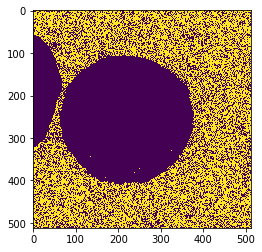

In [283]:
i = np.random.choice(range(nf))
plt.imshow(k_mean_img[i]==1)
plt.show()

In [292]:
tmp1 = img[k_mean_img==1]
tmp2 = img[k_mean_img==2]
tmp = np.concatenate([tmp1,tmp2])
img[k_mean_img==0] = np.random.choice(tmp,size=img[k_mean_img==0].shape)

In [445]:
cy,cx,h,w = (np.zeros(nf) for _ in range(4))
alpha = 0.1
addon = 8
for f in range(nf):
    contours = measure.find_contours(k_mean_br_img[f],.5)
    ll = 0
    for i, contour in enumerate(contours):
        if contour.size>ll:
            li = i
            ll = contour.size
    contour = contours[li]
    t = min(contour[:,0])-addon
    l = min(contour[:,1])-addon
    h[f] = max(contour[:,0])-min(contour[:,0])+2*addon
    cy[f] = t + h[f]/2
    w[f] = max(contour[:,1])-min(contour[:,1])+2*addon
    cx[f] = l + w[f]/2
    if f>0:
        h[f]  = alpha*h[f]  + (1-alpha)*h[f-1]
        cy[f] = alpha*cy[f] + (1-alpha)*cy[f-1]
        w[f]  = alpha*w[f]  + (1-alpha)*w[f-1]
        cx[f] = alpha*cx[f] + (1-alpha)*cx[f-1]

In [446]:
crop_img = np.zeros((nf,128,128))
for i in range(nf):
    min_y = max(int(cy[i]-h[i]/2),0)
    max_y = min(int(cy[i]+h[i]/2),511)
    min_x = max(int(cx[i]-w[i]/2),0)
    max_x = min(int(cx[i]+w[i]/2),511)
    crop_img[i] = np.array(Image.fromarray(img[i,min_y:max_y,min_x:max_x]).resize(size=(128,128),resample=Image.LANCZOS))
    cy[i] = (min_y + max_y)/2
    h[i]  =  max_y - min_y
    cx[i] = (min_x + max_x)/2
    w[i]  =  max_x - min_x

In [447]:
alpha = 0.15
xy = np.zeros((nf,2,num_angles))
for i in range(nf):
    contours = measure.find_contours(k_mean_br_img[i],.5)
    ll = 0
    for idx, contour in enumerate(contours):
        if contour.size>ll:
            li = idx
            ll = contour.size
    contour = contours[li]
    r = np.sqrt((contour[:,1]-cx[i])**2+(contour[:,0]-cy[i])**2)
    th = np.arctan2(contour[:,0]-cy[i],contour[:,1]-cx[i])+np.pi
    angs = np.argmin(np.abs(th.reshape(-1,1)-angles.reshape(1,-1)),axis=0)
    xy[i] = np.array([-r[angs]*np.cos(th[angs])/w[i]+63.5/128, -r[angs]*np.sin(th[angs])/h[i]+63.5/128])
    if i>0:
        xy[i] = alpha*xy[i] + (1-alpha)*xy[i-1]

In [448]:
fig,ax = plt.subplots(figsize=[8,8])
ax.set_xlim(( 0, 128))
ax.set_ylim((0, 128))
im0 = ax.imshow(crop_img[0], animated=True)
p0, = plt.plot(128*xy[0][0,:],128*xy[0][1,:],'ro')
def init():
    im0.set_array([[]])
    p0.set_xdata([np.nan]*num_angles)
    p0.set_ydata([np.nan]*num_angles)
    return im0, p0, 
def animate(i,y0):
    im0.set_array(y0[i])
    p0.set_xdata(128*xy[i][0,:])
    p0.set_ydata(128*xy[i][1,:])
    return  im0, p0, 
anim = animation.FuncAnimation(fig, animate, init_func=init, frames=nf, fargs=[crop_img], interval=20, blit=False)
plt.close()
HTML(anim.to_html5_video())

In [449]:
with open(PATH+tif[:-4]+'_crop_data.pkl','wb') as f:
    pickle.dump((crop_img,xy,cx,cy,w,h),f)

In [451]:
import numpy.linalg as la

In [459]:
Sigma = crop_img.reshape(-1,128*128).T@crop_img.reshape(-1,128*128)/crop_img.shape[0]

In [460]:
u,s,_ = la.svd(Sigma)

In [473]:
uReduce = u[:,:9]

In [474]:
z = crop_img.reshape(-1,128*128)@uReduce

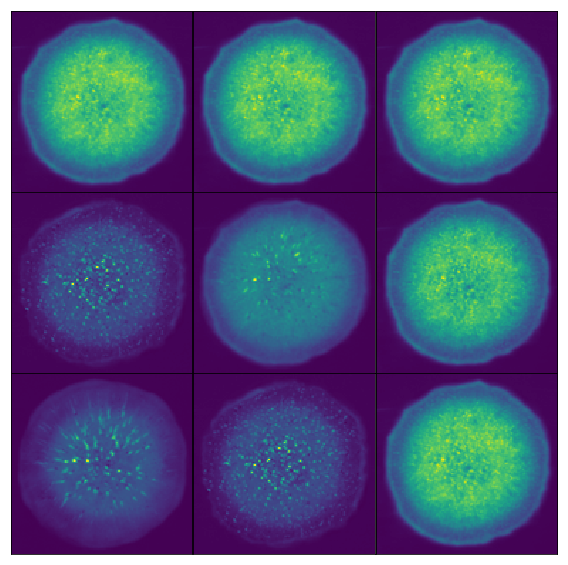

In [478]:
fig,ax = plt.subplots(3,3,figsize=[10,10])
ax = ax.flatten()
for i in range(9):
    k = np.random.choice(nf)
    ax[i].imshow((z@uReduce.T)[k,:].reshape(128,128).T)
    ax[i].set_xticks([])
    ax[i].set_yticks([])
fig.subplots_adjust(hspace=0.0,wspace=-.05)
plt.show()

In [480]:
fig,ax = plt.subplots(figsize=[8,8])
ax.set_xlim(( 0, 128))
ax.set_ylim((0, 128))
ax.set_xticks([])
ax.set_yticks([])
im0 = ax.imshow((z@uReduce.T)[0,:].reshape(128,128).T, animated=True)
def init():
    im0.set_array([[]])
    return im0,
def animate(i):
    im0.set_array((z@uReduce.T)[i,:].reshape(128,128).T)
    return  im0,
anim = animation.FuncAnimation(fig, animate, init_func=init, frames=nf, interval=20, blit=False)
plt.close()
HTML(anim.to_html5_video())

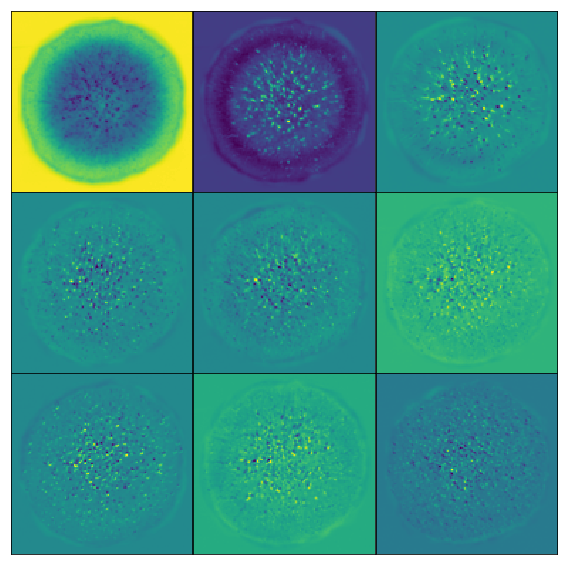

In [479]:
fig,ax = plt.subplots(3,3,figsize=[10,10])
ax = ax.flatten()
for i in range(9):
    ax[i].imshow(uReduce[:,i].reshape(128,128).T)
    ax[i].set_xticks([])
    ax[i].set_yticks([])
fig.subplots_adjust(hspace=0.0,wspace=-.05)
plt.show()